# 🟦 miniROS — Notebook 3
## Lidar Simulation & Reactive Obstacle Avoidance

In this notebook you will learn:
- How a 2D Lidar works in simulation
- How miniROS publishes a `LaserScan` on `/scan`
- How to subscribe to `/scan` inside a node
- How to build a **reactive obstacle avoidance controller**
- How to add simple circular obstacles to the world
- How to visualize lidar rays

**This notebook introduces real robotics behavior** used in TurtleBot and many indoor robots.

---
## Step 1 — Pull miniROS (updated version)
Make sure Notebook 2 was run before (updates installed).

In [1]:
!rm -rf miniROS
!git clone https://github.com/eder1234/miniROS.git
print("miniROS downloaded.")

Cloning into 'miniROS'...
remote: Enumerating objects: 56, done.
remote: Counting objects: 100% (56/56), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 56 (delta 25), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (56/56), 14.12 KiB | 4.71 MiB/s, done.
Resolving deltas: 100% (25/25), done.
miniROS downloaded.


## Step 2 — Import modules
We import the simulator, robot, messages, lidar, and obstacles modules.

In [2]:
import sys
sys.path.append('/content/miniROS')

from core.simulator import MiniRosSimulator
from robots.diffdrive import DiffDriveRobot
from sensors.lidar import Lidar2D
from world.obstacles import CircleObstacle
from core.messages import Twist, Pose2D, LaserScan
from core.node import Node

import matplotlib.pyplot as plt
import numpy as np

print("Imports OK.")

Imports OK.


## Step 3 — Create simulator, robot, obstacles, and lidar

We will place some circular obstacles around the robot.
The lidar has 36 beams (10° resolution).

In [7]:
sim = MiniRosSimulator(dt=0.05)

robot = DiffDriveRobot(
    init_pose=Pose2D(0,0.3,0),
    radius=0.2,
    cmd_topic="/cmd_vel"
)

sim.add_robot(robot)

# Obstacles
obstacles = [
    CircleObstacle(1.5, 0.5, 0.4),
    CircleObstacle(0.5, 1.2, 0.3),
    CircleObstacle(2.0, -0.5, 0.5)
]

# Lidar
lidar = Lidar2D(robot=robot, obstacles=obstacles, num_beams=36, max_range=4.0)
sim.add_lidar(lidar)

print("Robot, obstacles, and lidar added.")

Robot, obstacles, and lidar added.


## Step 4 — Visualize a single Lidar scan
We will show the rays and hits for one instant.


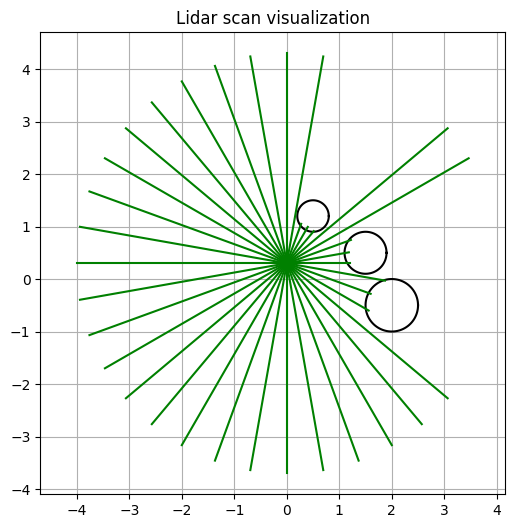

In [8]:
scan = lidar.scan()

plt.figure(figsize=(6,6))
plt.plot(robot.pose.x, robot.pose.y, 'ro', label='robot')

# Plot obstacles
theta = np.linspace(0, 2*np.pi, 90)
for obs in obstacles:
    plt.plot(obs.x + obs.radius*np.cos(theta),
             obs.y + obs.radius*np.sin(theta), 'k')

# Plot lidar beams
for r, a in zip(scan.ranges, scan.angles):
    x_end = robot.pose.x + r*np.cos(robot.pose.yaw + a)
    y_end = robot.pose.y + r*np.sin(robot.pose.yaw + a)
    plt.plot([robot.pose.x, x_end], [robot.pose.y, y_end], 'g-')

plt.axis('equal')
plt.grid(True)
plt.title("Lidar scan visualization")
plt.show()

## Step 5 — Obstacle Avoidance Node

We define a node that subscribes to `/scan` and implements:
- If front distance < 0.8 m → turn left
- Else → move forward


In [9]:
class ObstacleAvoidanceNode(Node):
    def __init__(self, topic="/cmd_vel"):
        super().__init__("avoidance")
        self.topic = topic
        self.front_beam_index = 0  # angle = 0
        self.safe_distance = 0.8

    def step(self, dt):
        scan = self.read_topic("/scan")
        if scan is None:
            return

        front = scan.ranges[self.front_beam_index]

        if front < self.safe_distance:
            # Turn left
            cmd = Twist(0.0, 1.0)
        else:
            # Move forward
            cmd = Twist(0.4, 0.0)

        self.publish(self.topic, cmd)

print("ObstacleAvoidanceNode ready.")

ObstacleAvoidanceNode ready.


## Step 6 — Run simulation and plot trajectory
The robot will:
- Move forward
- Turn left when obstacle detected
- Repeat

This is the simplest form of reactive navigation.

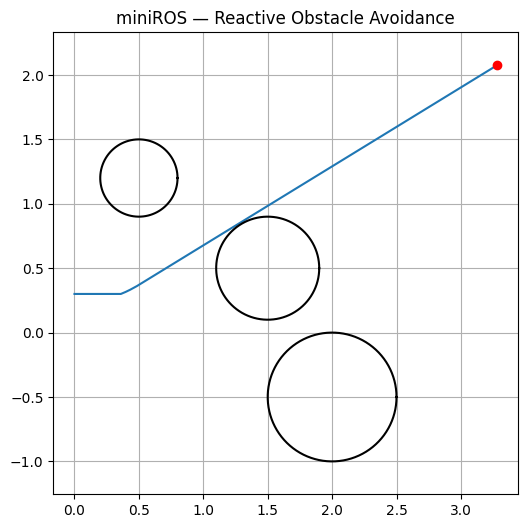

In [10]:
avoid = ObstacleAvoidanceNode()
sim.add_node(avoid)

sim.run(10.0)

plt.figure(figsize=(6,6))
plt.plot(robot.traj_x, robot.traj_y, label="trajectory")

theta = np.linspace(0,2*np.pi,100)
for obs in obstacles:
    plt.plot(obs.x + obs.radius*np.cos(theta),
             obs.y + obs.radius*np.sin(theta), 'k')

plt.plot(robot.pose.x, robot.pose.y, 'ro')
plt.axis('equal')
plt.grid(True)
plt.title("miniROS — Reactive Obstacle Avoidance")
plt.show()

---
# 🧪 Exercises

### **Exercise 1 — Full-Field Avoidance**
Turn away based on the **minimum distance across all beams**, not just the front beam.

### **Exercise 2 — Right-hand Wall Follower**
Use beams on the robot’s right side to follow a wall.

### **Exercise 3 — Noise Injection**
Add random noise to the Lidar readings.

### **Exercise 4 — Multi-Obstacle Navigation**
Add more obstacles and tune the controller.

### **Exercise 5 — Lidar Visualization Node**
Create a node that logs or plots the scan values.

---
## End of Notebook 3
Next: **Notebook 4 — Occupancy Grid Mapping (SLAM concepts)**
